In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

In [2]:
customer_profiles_df=pd.read_csv("./data/customer_profiles_table.csv")
transactions_df=pd.read_csv("./data/transactions_df.csv")
terminal_profiles_df=pd.read_csv("./data/terminal_profiles_table.csv")

# Exploratory data analysis notebook & statistical analysis

This project will use a data set generator created by [Yann-Aël Le Borgne & Gianluca Bontempi](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html). The generator will create three dataset that reproduce the logs of a fictional card company, including fraudulent transactions by fraudsters. 

The logs are split in three dataset, column name in lower case are directly linked to the main dataset **transactions_df**:

1 - Customer profile

| Column | Type | Description |
| --- | --- | --- |
| CUSTOMER_ID | int64 | The customer unique ID|
|(x_customer_id,y_customer_id) | float64 | A pair of real coordinates (x_customer_id,y_customer_id) in a 100 * 100 grid, that defines the geographical location of the customer |
|(mean_amount, std_amount) | float64 | The mean and standard deviation of the transaction amounts for the customer, assuming that the transaction amounts follow a normal distribution. The mean_amount will be drawn from a uniform distribution (5,100) and the std_amount will be set as the mean_amount divided by two.|
| mean_nb_tx_per_day | float64 | The average number of transactions per day for the customer, assuming that the number of transactions per day follows a Poisson distribution. This number will be drawn from a uniform distribution (0,4) |

The generate_customer_profiles_table function provides an implementation for generating a table of customer profiles. It takes as input the number of customers for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each customer.

In [3]:
customer_profiles_df.dtypes

CUSTOMER_ID              int64
x_customer_id          float64
y_customer_id          float64
mean_amount            float64
std_amount             float64
mean_nb_tx_per_day     float64
available_terminals     object
nb_terminals             int64
dtype: object

In [4]:
customer_profiles_df.head()

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals
0,0,54.881350,71.518937,62.262521,31.131260,2.179533,"[29, 87, 144, 241, 330, 858, 996]",7
1,1,42.365480,64.589411,46.570785,23.285393,3.567092,"[5, 160, 242, 378, 431, 475, 571, 762, 876, 93...",12
2,2,96.366276,38.344152,80.213879,40.106939,2.115580,"[316, 406, 447, 523, 968]",5
3,3,56.804456,92.559664,11.748426,5.874213,0.348517,"[65, 94, 113, 364, 401, 433, 485, 651, 672, 77...",14
4,4,2.021840,83.261985,78.924891,39.462446,3.480049,"[372, 614, 774]",3


In [5]:
customer_profiles_df.shape

(5000, 8)

In [6]:
customer_profiles_df.describe()

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,nb_terminals
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2499.500000,49.626386,50.013166,51.797573,25.898787,1.977582,7.51520
std,1443.520003,28.991158,29.081224,27.779156,13.889578,1.154736,3.00406
min,0.000000,0.007245,0.020695,5.032382,2.516191,0.000295,0.00000
25%,1249.750000,24.417225,24.808494,27.885592,13.942796,0.977653,5.00000
50%,2499.500000,49.462662,50.073791,51.681424,25.840712,1.952286,7.00000
75%,3749.250000,74.615700,75.910068,75.633210,37.816605,2.996354,9.00000
max,4999.000000,99.996202,99.996402,99.981815,49.990907,3.999912,19.00000


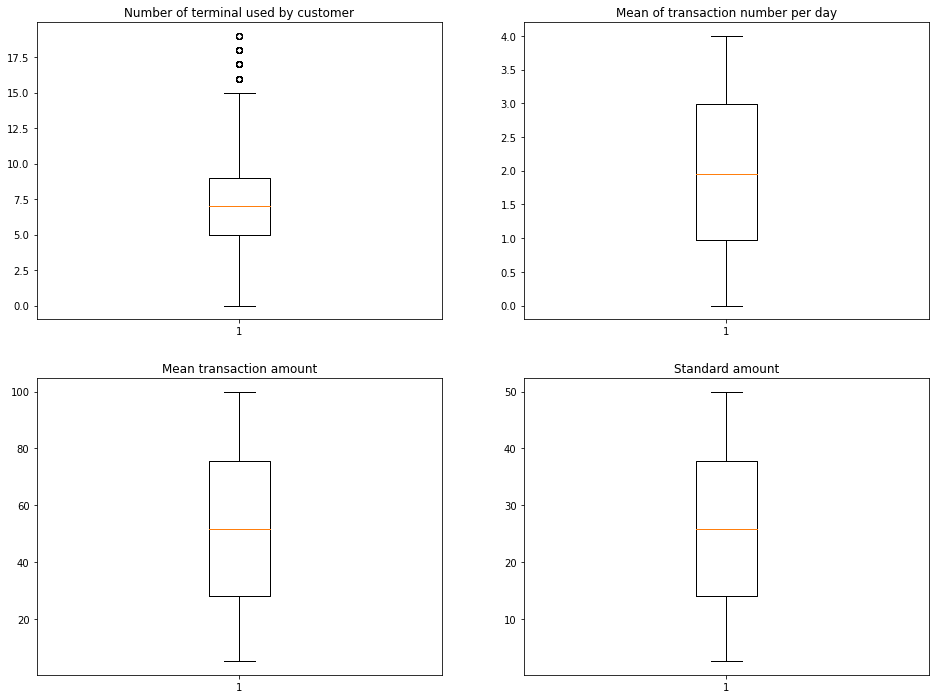

In [7]:
fig, ax = plt.subplots(2,2,figsize=(16,12))

ax[0][0].boxplot(customer_profiles_df["nb_terminals"])
ax[1][0].boxplot(customer_profiles_df["mean_amount"])
ax[0][1].boxplot(customer_profiles_df["mean_nb_tx_per_day"])
ax[1][1].boxplot(customer_profiles_df["std_amount"])

ax[0][0].title.set_text("Number of terminal used by customer")
ax[1][0].title.set_text("Mean transaction amount")
ax[0][1].title.set_text("Mean of transaction number per day")
ax[1][1].title.set_text("Standard amount")


plt.show()


2 - Transaction list

| Column | Type | Description |
| --- | --- | --- |
| TRANSACTION_ID  | int64 | A unique identifier for the transaction|
| TX_DATETIME  | object | Date and time at which the transaction occurs|
| CUSTOMER_ID  | int64 | The identifier for the customer. Each customer has a unique identifier|
| TERMINAL_ID  | int64 | The identifier for the merchant (or more precisely the terminal). Each terminal has a unique identifier|
| TX_AMOUNT	  | int64 | The amount of the transaction|
| TX_FRAUD  | int64 | A binary variable, with the value 0 for a legitimate transaction, or the value 1 for a fraudulent transaction|
| TX_FRAUD_SCENARIO | int64 | Referencing the fraud scenario, 0 indicate a genuine transaction|

* Fraud scenario:

Scenario 1: Any transaction whose amount is more than 220 is a fraud. This scenario is not inspired by a real-world scenario. Rather, it will provide an obvious fraud pattern that should be detected by any baseline fraud detector. This will be useful to validate the implementation of a fraud detection technique.

Scenario 2: Every day, a list of two terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent. This scenario simulates a criminal use of a terminal, through phishing for example. Detecting this scenario will be possible by adding features that keep track of the number of fraudulent transactions on the terminal. Since the terminal is only compromised for 28 days, additional strategies that involve concept drift will need to be designed to efficiently deal with this scenario.

Scenario 3: Every day, a list of 3 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. The customer continues to make transactions, and transactions of higher values are made by the fraudster who tries to maximize their gains. Detecting this scenario will require adding features that keep track of the spending habits of the customer. As for scenario 2, since the card is only temporarily compromised, additional strategies that involve concept drift should also be designed.

In [8]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,298,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,441,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,316,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,370,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,415,50.99,634,0,0,0


In [9]:
transactions_df.shape

(1750048, 9)

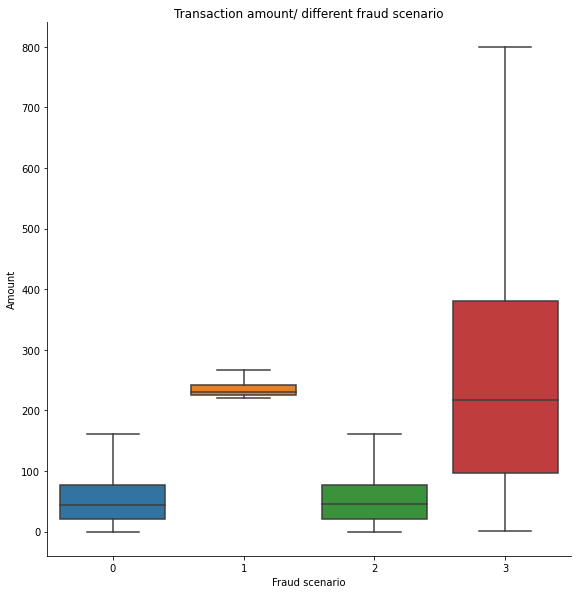

In [10]:
sns.displot(color = "rocket", height=8)

ax = sns.boxplot(x = "TX_FRAUD_SCENARIO",y = "TX_AMOUNT", data= transactions_df, showfliers = False)
ax.set_title("Transaction amount/ different fraud scenario")
ax.set_ylabel("Amount")
ax.set_xlabel("Fraud scenario");

In [11]:
genuine = transactions_df[transactions_df.TX_FRAUD_SCENARIO == 0]
genuine = genuine.groupby(by = "TX_TIME_DAYS").sum()

fraud = transactions_df[(transactions_df.TX_FRAUD_SCENARIO != 0)]
                       
fraud = fraud.groupby(by = "TX_TIME_DAYS").sum()

genuine_max = genuine.index.max() +1

In [12]:
days = []
for i in range (0, genuine_max):
    days.append(i)
    
genuine_data = []
for i in genuine.TX_AMOUNT:
    genuine_data.append(i)
    
fraud_data = []
for i in fraud.TX_AMOUNT:
    fraud_data.append(i)


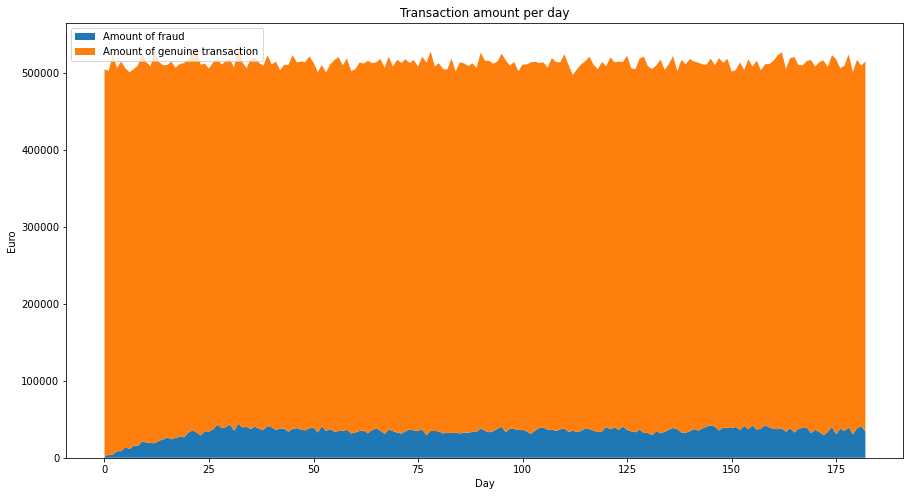

In [13]:
f_types = {
    "Amount of fraud": list(fraud_data),
    "Amount of genuine transaction": list(genuine_data)
}

fig, ax = plt.subplots(figsize=(15,8))
ax.stackplot(days, f_types.values(),
             labels=f_types.keys())


ax.legend(loc='upper left')
ax.set_title("Transaction amount per day")
ax.set_xlabel("Day")
ax.set_ylabel("Euro")

plt.show()

In [14]:
genuine_count = transactions_df[transactions_df.TX_FRAUD_SCENARIO == 0]
genuine_count = genuine_count.groupby(by = "TX_TIME_DAYS").count()

fraud_count = transactions_df[(transactions_df.TX_FRAUD_SCENARIO != 0)]                    
fraud_count = fraud_count.groupby(by = "TX_TIME_DAYS").count()

genuine_max_count = genuine_count.index.max() +1

In [15]:
genuine_data_count = []
for i in genuine_count.TX_AMOUNT:
    genuine_data_count.append(i)
    
fraud_data_count = []
for i in fraud_count.TX_AMOUNT:
    fraud_data_count.append(i)


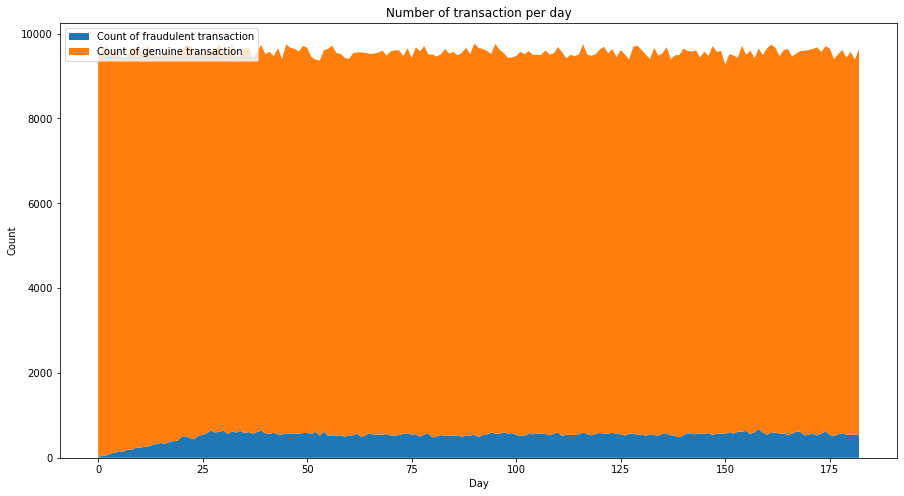

In [16]:
f_types_count = {
    "Count of fraudulent transaction": list(fraud_data_count),
    "Count of genuine transaction": list(genuine_data_count)
}

fig, ax = plt.subplots(figsize=(15,8))
ax.stackplot(days, f_types_count.values(),
             labels=f_types_count.keys())


ax.legend(loc='upper left')
ax.set_title("Number of transaction per day")
ax.set_xlabel("Day")
ax.set_ylabel("Count")

plt.show()

3 - Terminal profile

| Column | Type | Description |
| --- | --- | --- |
| TERMINAL_ID | int64 | The terminal ID|
| (x_terminal_id,y_terminal_id) | float64 | A pair of real coordinates (x_terminal_id,y_terminal_id) in a 100 * 100 grid, that defines the geographical location of the terminal|

The generate_terminal_profiles_table function provides an implementation for generating a table of terminal profiles. It takes as input the number of terminals for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each terminal.

In [17]:
terminal_profiles_df.head()

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,41.702200,72.032449
1,1,0.011437,30.233257
2,2,14.675589,9.233859
3,3,18.626021,34.556073
4,4,39.676747,53.881673


In [18]:
terminal_profiles_df.describe()

,TERMINAL_ID,x_terminal_id,y_terminal_id
count,1000.000000,1000.000000,1000.000000
mean,499.500000,49.956215,51.915484
std,288.819436,28.829699,29.352825
min,0.000000,0.011437,0.076439
25%,249.750000,25.225258,25.786456
50%,499.500000,50.644941,53.343652
75%,749.250000,75.067127,77.541853
max,999.000000,99.852051,99.841356


In [19]:
terminal_profiles_df.shape

(1000, 3)

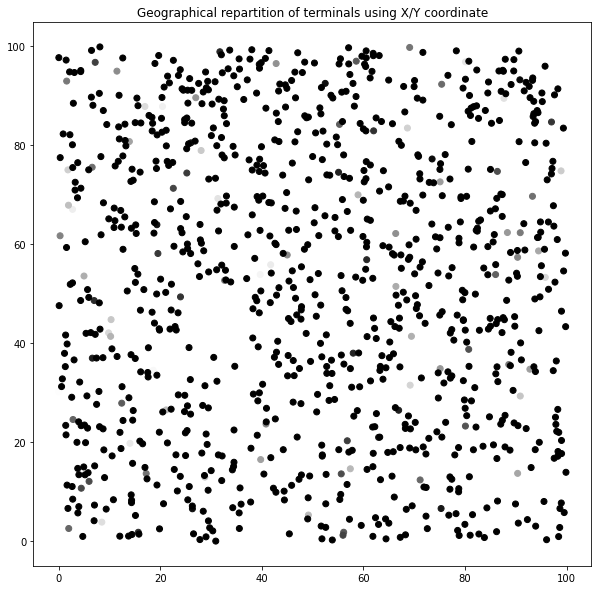

In [20]:

plt.figure(figsize=(10,10))
plt.scatter(list(terminal_profiles_df.x_terminal_id), list(terminal_profiles_df.y_terminal_id), 
             c=list(terminal_profiles_df.TERMINAL_ID),cmap="binary", vmin=0, vmax=100)
plt.title("Geographical repartition of terminals using X/Y coordinate")
plt.show();

# Next step

Once each data set generated the project will have two main steps.

**1 -** Using machine learning, build an engine that will be able to generate a risk score for each transaction. The engine has to be able to update its parameters over time considering uncertainty period.

**NB: Uncertainty period.** In real world, credit card companies have to deal with timeframe related problematics. When a customer wants to make a transaction, companies have few seconds to decide if this transaction is allowed or not. On the customer side, the genuine owner of the credit card has up to 180 days to create a dispute. 
This means that when companies allow a transaction, the quality of the decision won't be totally defined before this period. From experience, in a fraud situation, a genuine card owner will contest a fraudulent transaction under 20 days, mostly after 5.

**2 -** Build a risk decision system using the risk score generated by the engine and parameters driven by the business to take a decision on new transactions : Pass, Review or Deny. The parameters have to balance the risk of false negative and positive; and only review transactions that are in a strong grey area in order to avoid long review time frames due to overloaded teammates.
